In [1]:
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

torch.set_grad_enabled(False)


/home/milesw/miniconda3/envs/rome/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "/net/scratch/milesw/gpt2xl_outputs_14"  # or "gpt2-xl" or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,  # Set to False since you're not using Google Colab
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

In [3]:
mt.model.config.use_cache = True

In [ ]:
def make_inputs(tokenizer, prompts, device="cuda"):
    token_lists = [tokenizer.encode(p) for p in prompts]
    maxlen = max(len(t) for t in token_lists)
    if "[PAD]" in tokenizer.all_special_tokens:
        pad_id = tokenizer.all_special_ids[tokenizer.all_special_tokens.index("[PAD]")]
    else:
        pad_id = 0
    input_ids = [[pad_id] * (maxlen - len(t)) + t for t in token_lists]
    # position_ids = [[0] * (maxlen - len(t)) + list(range(len(t))) for t in token_lists]
    attention_mask = [[0] * (maxlen - len(t)) + [1] * len(t) for t in token_lists]
    return dict(
        input_ids=torch.tensor(input_ids).to(device),
        #    position_ids=torch.tensor(position_ids).to(device),
        attention_mask=torch.tensor(attention_mask).to(device),
    )

def predict_token(mt, prompts, return_p=False, temp: float = 0):
    inp = make_inputs(mt.tokenizer, prompts)
    preds, p = predict_from_input(mt.model, inp, temp=temp)
    result = [mt.tokenizer.decode(c) for c in preds]
    if return_p:
        result = (result, p)
    return result


def predict_from_input(model, inp, temp: float = 0):
    out = model(**inp)["logits"]
    probs = torch.softmax(out[:, -1], dim=1)
    
    if temp == 0:
        p, preds = torch.max(probs, dim=1)
    else:
        preds = torch.multinomial(probs, num_samples=1)
        p = probs[torch.arange(probs.shape[0]), preds[:, 0]]

    return preds, p


def predict_multiple_tokens(
    mt,
    prompts: list[str],
    n_tokens: int = 3,
):
    results, ps = [], []
    for _ in range(n_tokens):
        result, p = predict_token(mt, prompts, return_p=True)
        results.append(result)
        ps.append(p.item())

        prompts = [p + r for p, r in zip(prompts, result)]

    return results, ps

def print_multiple_tokens(mt, prompt, n_tokens=3, temp: float = 0):
    for i in range(n_tokens):
        result, = predict_token(mt, [prompt], return_p=False, temp=temp)
        print(result, end="")
        if (i + 1) % 30 == 0:
            print()
        prompt += result


In [ ]:
predict_multiple_tokens(
    mt,
    ["Megan Rapinoe plays the sport of"],
    n_tokens=3,
)

([[' soccer'], ['.'], [' She']],
 [0.9374613165855408, 0.4076204001903534, 0.5683636665344238])

In [ ]:
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

data/known_1000.json does not exist. Downloading from https://rome.baulab.info/data/dsets/known_1000.json


100%|██████████| 335k/335k [00:00<00:00, 3.56MB/s]


Loaded dataset with 1209 elements
Using noise level 0.1350100077688694


In [3]:
def count_words(
    mt,
    prompt: str,
    words_to_check: dict[str],
    n_tokens: int = 20,
    n_iters: int = 10,
    temp: int = 1.0,
) -> dict[str, int]:
    counter = {word: 0 for word in words_to_check}
    for _ in range(n_iters):
        results, _ = predict_multiple_tokens(mt, [prompt], n_tokens=n_tokens, temp=temp)
        results_flat = [
            item for sublist in results for item in sublist
        ]  # Flatten the list
        for result in results_flat:
            for word in words_to_check:
                if word in result:
                    counter[word] += 1
    for word, count in counter.items():
        print(
            f"The word '{word}' appeared {count} times in {n_iters} predictions of {n_tokens} tokens each."
        )
    return counter

In [ ]:
# NEW CAUSAL TRACE

def trace_with_patch(
    model,  # The model
    mt, # model + tokenizer
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    words_to_check,  # List of words to check in the output
    n_tokens=20,  # Number of tokens to generate
    n_iters=10,  # Number of times to run the generation
    temp=1.0,  # Temperature for the generation
    s_range=None,  # Range of S tokens to remove
    q_range=None,  # Range of Q tokens to patch
    trace_layers=None,  # List of traced outputs to return
):
    # Create a defaultdict that will hold the list of token indices to restore for each layer
    patch_spec = defaultdict(list) 
    # For each token index, layername pair in states_to_patch
    for t, l in states_to_patch:
        # Append the token index to the list of token indices for this layer
        patch_spec[l].append(t)

    # Get the layer name of the embedding layer
    embed_layername = layername(model, 0, "embed")

    # Helper function to handle outputs that may be tuples instead of tensors
    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer, s_range, q_range):
        # If we're at the embedding layer
        if layer == embed_layername:
            # If a range of S tokens was provided
            if s_range is not None:
                b, e = s_range
                # Set the embeddings of these tokens to zero
                x[1:, b:e] = 0  
            # If a range of Q tokens was provided
            if q_range is not None:
                b, e = q_range
                # Replace the embeddings of these tokens with their original values
                x[1:, b:e] = x[0, b:e]
            # Return the modified tensor
            return x
        # If this layer is not in the patch_spec, return the tensor as is
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        # For each token index in this layer's list
        for t in patch_spec[layer]:
            # Replace the hidden state of this token with its original value
            h[1:, t] = h[0, t]
        # Return the modified tensor
        return x

    # If no trace_layers were specified, use an empty list
    additional_layers = [] if trace_layers is None else trace_layers
    # Enter a no_grad context to disable gradient computation
    with torch.no_grad(), nethook.TraceDict(
        model,  # The model to trace
        # The layers to trace
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        # The function to use to modify the layer outputs
        edit_output=partial(patch_rep, s_range=s_range, q_range=q_range),
    ) as td:
        # Count the occurrences of the specified words in the model's outputs
        counter = count_words(mt, inp, words_to_check, n_tokens=n_tokens, n_iters=n_iters, temp=temp)

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        # Collect the traced outputs for each layer into a single tensor
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        # Return the word counter and the traced outputs
        return counter, all_traced

    # If not tracing all layers, just return the word counter
    return counter

In [7]:
# OLD CAUSAL TRACE

def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x): # for layers that output tuples (such as hidden states and attention weights, return first element) TODO: which element is this
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

In [8]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

In [9]:
def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind
        )

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

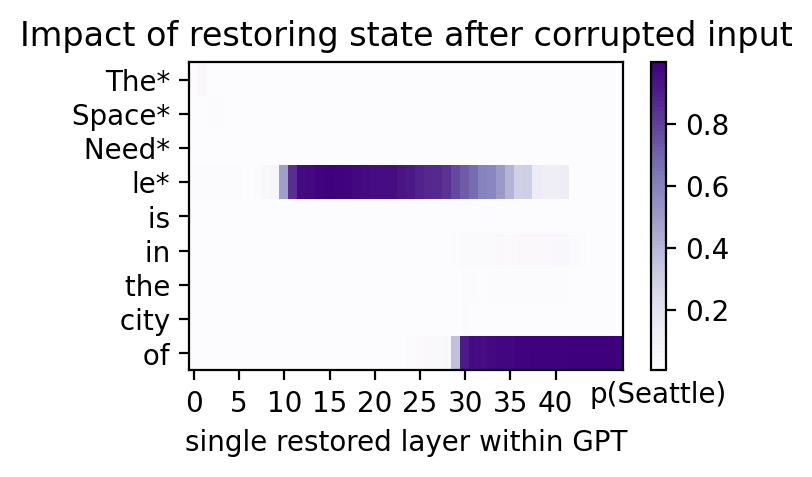

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

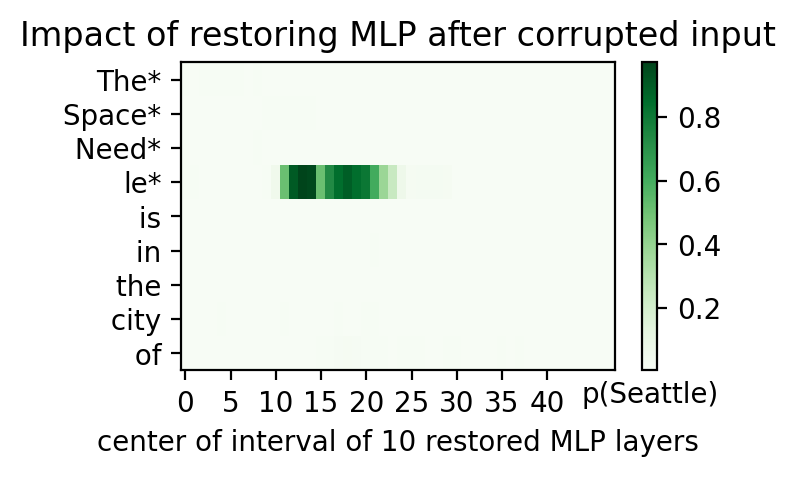

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

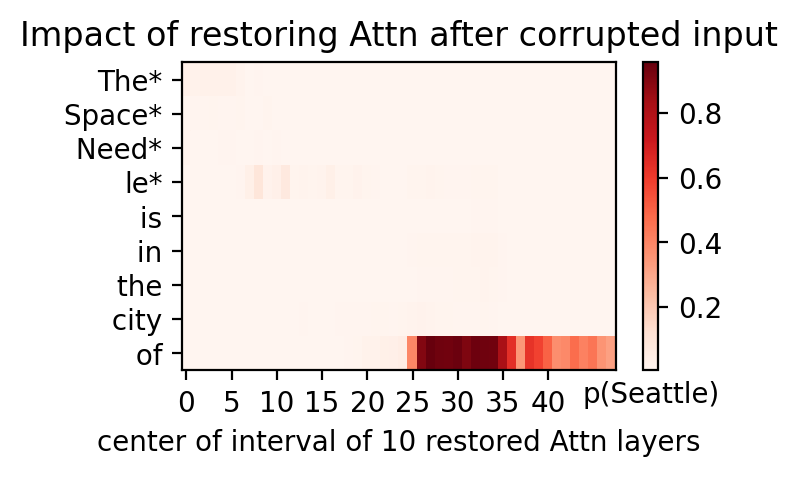

In [10]:
plot_all_flow(mt, "The Space Needle is in the city of", noise=noise_level)